In [1]:
library(data.table)
# library(pracma) # only needed for moving-average plot
load('../data/cancer_type_pd_th25.rda') # probabilities of each mutation type

In [2]:
birthrate <- function(nd, np, sd, sp, tau) { # probability of birth per timestep
    return((((1+sd)^nd)/((1+sp)^np))*tau)
}
delta_ncells <- function(B, D, ncells) { # change in number of cells for a clone
    return (max(ncells + rbinom(1,ncells,min(B,1))-rbinom(1,ncells,min(D,1)),0))
}
get_mu_i <- function(B, mu) {return(mu*B)} # mutation rate of clone i: proportional to birth rate
get_ntrans <- function(ncells, mu_i) {return (rbinom(1,ncells,mu_i))} # number of transpositions in current clone

In [3]:
# This function simulates the evolution of a cell population subject to L1 insertions over time.
# By default, a single cell is initialized with a driver mutation.
#
# Inputs:
#     N0 - initial population size (# cells)
#     mu - mutation rate (# L1 transpositions / birth)
#     tau - time resolution (# number of timesteps / birth of normal cell)
#     NT - number of timesteps to simulate
#     sd - driver selection strength (positive change in birth rate for each accumulated driver)
#     sp - passenger selection strength (negative change in birth rate for each accumulated passenger)
#     maxNClones - Buffer size of population data object; represents the max possible number of clones in the population
#     pd_mut - Discrete probability distribution of mutation types assumed to be in the order: driver, passenger, null, and sum to 1
#
# Outputs:
#     Pop - data.table object containing a row for each clone in the final population, along
#           with columns for number of drivers and passengers, birth rate, mutation rate, number of cells
#     N - Array containing the population size over time

run_sim <- function(N0, mu, tau, NT, sd, sp, maxNClones, pd_mut) {

    Pop <- data.table(ncells=rep(0,maxNClones),nd=rep(0,maxNClones),np=rep(0,maxNClones),B=rep(0,maxNClones),mu_i=rep(0,maxNClones))
    Pop[1:2,c('ncells','nd','np'):=list(c(N0-1,1),c(0,1),c(0,0))] # populations are initialized with a driver mutation in a single cell
    Pop[1:2,B := mapply(birthrate,nd,np,sd,sp,tau)]
    Pop[1:2,mu_i := mapply(get_mu_i, B, mu)]

    N <- rep(0,NT)
    pd_mut <- pd_mut[1:2]/sum(pd_mut[1:2])

#     ptm <- proc.time()
    for (ii in 1:NT) {

        clog <- Pop$ncells>0 # get logical array for indices of active (# cells >0) clones
        
        ntrans <- sum(mapply(get_ntrans,Pop$ncells[clog],Pop$mu_i[clog])) # get number of pass/driver mutations
        if (ntrans > 0) {
            
            rownew <- which(Pop$ncells==0)[1] # find first row of the data table with ncells==0

            types <- sample(1:2,ntrans,replace=TRUE,prob=pd_mut) # sample mutation types
            nmu <- length(types) # total number of passenger and drivers

            sampctr <- sample(rep(1:maxNClones,Pop$ncells),nmu,replace=FALSE) # list clone id of each cell; sample without replacement
            ctab <- table(sampctr)
            cids <- as.integer(names(ctab)) # get row ids of sampled clones
            set(Pop,cids,1L,Pop[cids,1L] - as.integer(ctab)) # remove cells from sampled clones

            # Populate the new rows representing new clones
            Pop[rownew:(rownew+nmu-1), c("ncells","nd","np"):=list(1, Pop[sampctr]$nd+((types==1)*1), Pop[sampctr]$np+((types==2)*1))]
            Pop[rownew:(rownew+nmu-1), B := mapply(birthrate, nd, np, sd, sp, tau)]
            Pop[rownew:(rownew+nmu-1), mu_i := mapply(get_mu_i, B, mu)]
        }

        N[ii] <- sum(Pop$ncells) # get current number of cells
        if (N[ii]>=3*N0) {break} # simulation stops if population has grown by 5X
        D <- N[ii]*tau/N0        # compute death rate
        Pop[Pop$ncells>0, ncells:=mapply(delta_ncells, B, D, ncells)] # update number of cells for all clones
        Pop <- Pop[order(Pop$ncells,decreasing=TRUE),] # order data.table by ncells

    }
#     print(proc.time() - ptm)

    return(list(Pop,N))

}


### Define parameters

In [4]:
# Initial number of cells
N0 <- 5e3
# Probability of passenger or driver L1 insertion per generation per cell
mu <- 10
mu <- mu*(1-pd_lung[3]) # Scale by 1-probability of null mutation
# Driver and passenger mutation selection strengths
sd <- .1
sp <- .001


# Time resolution: number of timesteps per cell cycle in the initial population
tau <- 4
tau <- 1/tau
# Number of time steps to simulate
NT <- 5e3
# Buffer size of population data object; represents the max possible number of clones in the population
maxNClones <- max(2000,N0*4)

Test run

ncells,nd,np,B,mu_i
3,25,1205,1.0830101,0.3412591
3,24,1197,0.9924587,0.3127261
3,24,1203,0.9865247,0.3108563
3,24,1188,1.0014266,0.3155520
2,24,1199,0.9904768,0.3121016
2,24,1211,0.9786679,0.3083806


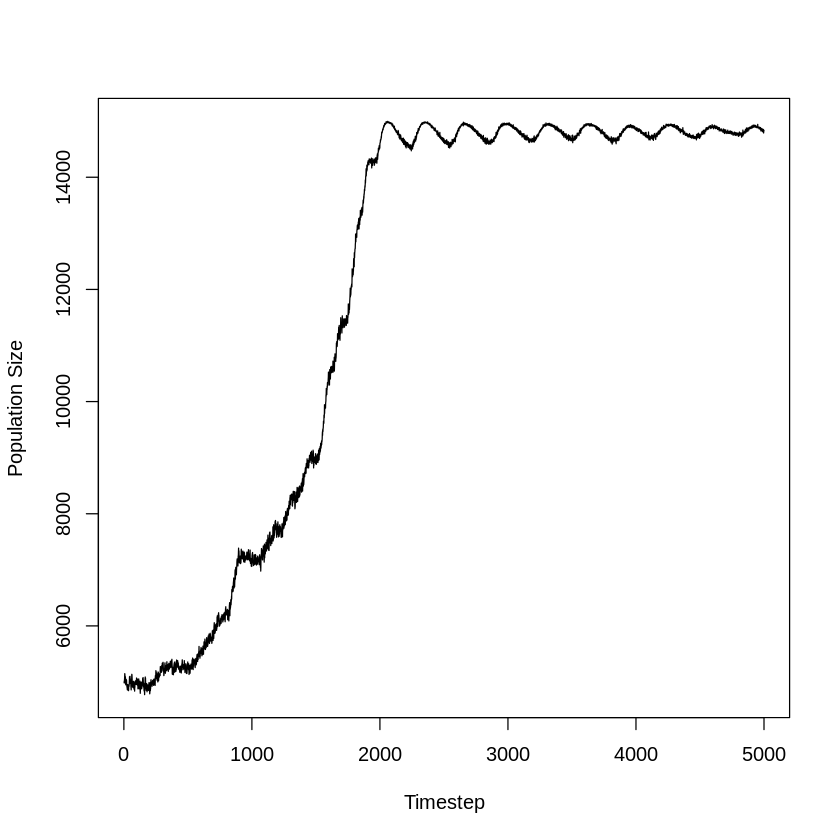

In [14]:
out <- run_sim(N0, mu, tau, NT, sd, sp, maxNClones, c(1400,1e7))
Pop <- out[[1]]
N <- out[[2]]

head(Pop)
plot(1:NT,N,type='l',xlab='Timestep',ylab='Population Size')
# plot((1:NT)*tau,movavg(N,200,'s'),type='l',xlab='Generation',ylab='Population Size')

Batch run

In [ ]:
load('../data/cancer_type_pd_th25.rda') # probabilities of each mutation type
nrun <- 0
muv <- c(1e-4,1e-3,1e-2,1e-1,1e-0)
muv_adj <- muv*(1-pd_lung[3])
N0v <- c(1e2,5e2,1e3,2e3,5e3)
outPath <- '../../jupytest_sim/run'
for (ii in 1:length(N0v)){
    for (jj in 1:length(muv)) {
        nrun <- nrun+1
        line <- paste0('Run: ',toString(nrun),'\tN0: ',toString(N0v[ii]),'\tmu: ',toString(muv[jj]))
        write(line,file=paste0(outPath,'.log'),append=TRUE)
        out <- run_sim(N0v[ii], muv_adj[jj], tau, NT, sd, sp, N0v[ii]*4, c(1400,1e7))
        Pop <- out[[1]]
        N <- out[[2]]
        save(Pop,N,file=paste0(outPath,'_n0',N0v[ii],'_',nrun,".rda"))
        rm(Pop,N)
    }
}